In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
import torchvision
from tqdm import tqdm
import random
import numpy as np
from collections import OrderedDict

from PIL import Image, ImageDraw, ImageFont

from matplotlib import pyplot as plt
import time
import os
from pathlib import Path

In [32]:

test_image_path = Path("characters_cuts")

## Helpers

In [33]:
def show_batch(x,y,shape = None):
    """
    input: 
        x(Tensor[num_images, rows, columns]): images tensor
        y(array): labels
        shape(tuple): (rows,col) 
    output:
        grid of smaple images
    """

    if not shape:
        shape = (int(x.shape[0]**0.5), int(x.shape[0]**0.5))

    fig, axs = plt.subplots(nrows= shape[0], ncols=shape[1], figsize = (12,8))
    index = 0
    for row in axs:
        for ax in row:
            ax.imshow(x[index])
            ax.set_xlabel(y[index], )
            index+=1

    # plt.subplots_adjust(wspace = 0.2, hspace = 0.5) 
    fig.tight_layout()
    plt.show()

In [34]:
chars = set()
for p in test_image_path.glob("*.png"):
    chars.add(p.name.split(".")[0])
chars = list(chars)

In [35]:
font_paths = ["ttf/Fangsong.ttf", "ttf/Kaiti.ttf"]

## Hyper-parameters

In [36]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
RANDOM_SEED = 42

DEVICE = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

## Datasets

In [75]:
class CaptchaDataset(Dataset):
    
    def __init__(self, chars, font_paths, train, transforms, multiple = 50):
        super(CaptchaDataset, self).__init__()
        
        self.chars = chars
        self.char2index = {char:index for char, index in zip(self.chars, range(len(self.chars)))}
        self.index2char = {index:char for char, index in zip(self.chars, range(len(self.chars)))}
        
        self.multiple = multiple
        
        self.all_words = self.chars * multiple
        random.shuffle(self.all_words)        
        
        self.bgColor = (255, 255, 255)
        self.fontColor = (0, 0, 0)
        self.image_size = (42,42)
        self.font_size = 28
        
        self.font_paths = font_paths
        self.train = train
        self.transforms = transforms
        

    def __len__(self):
        return len(self.all_words)
    
    def drawText(self, pos, txt,font,image, fill):
        draw = ImageDraw.Draw(image)
        draw.text(pos, txt, font=font, fill= fill)
        del draw
    
    def __getitem__(self, index):
        word = self.all_words[index]
        font_path = random.choice(self.font_paths)
        img =  Image.new('RGB', self.image_size, self.bgColor)
        font = ImageFont.truetype(font_path, self.font_size)
        
        self.drawText((5,3), word, font, img, self.fontColor)

        if self.transforms:
            img = self.transforms(img)
        else:
            img = T.functional.to_tensor(img)
            
        target = torch.tensor(self.char2index[word])
        
        return img, target

class TestDataset(Dataset):
    def __init__(self,chars, test_image_root, transfroms = None):
        
        self.chars = chars
        self.char2index = {char:index for char, index in zip(self.chars, range(len(self.chars)))}
        self.index2char = {index:char for char, index in zip(self.chars, range(len(self.chars)))}
        
        self.test_images = list(test_image_root.glob("*.png"))
        self.transforms = transfroms
        
    def __len__(self):
        return len(self.test_images)
    
    def __getitem__(self, idx):
        image = Image.open(self.test_images[idx])
        name = self.test_images[idx].name.split(".")[0]
        
        if self.transforms:
            image = self.transforms(image)
        
        target = self.char2index[name]
        return image,target

In [79]:
train_transforms = T.Compose([
                        T.RandomRotation(30,fill = (255,255,255)),
                        T.CenterCrop(size = 32),  
                        T.ColorJitter(contrast = 0.4, saturation = 0.4),
                        T.RandomGrayscale(p=1.0),
                        T.ToTensor(),
                        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),      
                    ])

test_data_transform = T.Compose([
    T.Resize(32),
    T.RandomGrayscale(p=1.0),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = CaptchaDataset(chars, font_paths, train = True, transforms = train_transforms,multiple= 30)
val_dataset = CaptchaDataset(chars, font_paths, train = True, transforms = train_transforms,multiple=5)
test_dataset = TestDataset(chars, test_image_path,test_data_transform)


train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=True)

val_dataloader = DataLoader(dataset = val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=4,
                             shuffle=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size = BATCH_SIZE, 
                                                  num_workers=4,
                                                  shuffle = False)

dataset_loader = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [80]:
image, target = next(iter(train_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

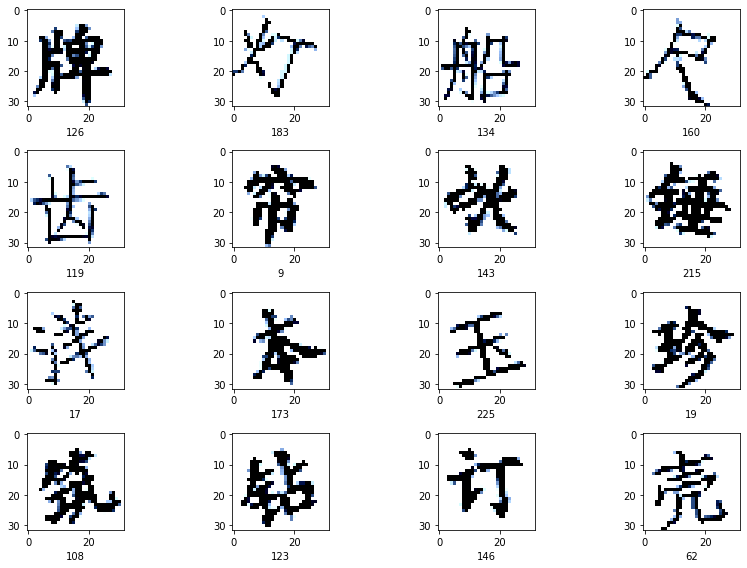

In [81]:
show_batch(image.permute([0,2,3,1]), target.numpy(), (4,4))

In [82]:
"".join([train_dataset.index2char[item] for item in target.numpy()])[:16]

'牌灯船尺齿帘冰锤洋本玉珍筑钻订壳'

In [83]:
image, target = next(iter(test_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

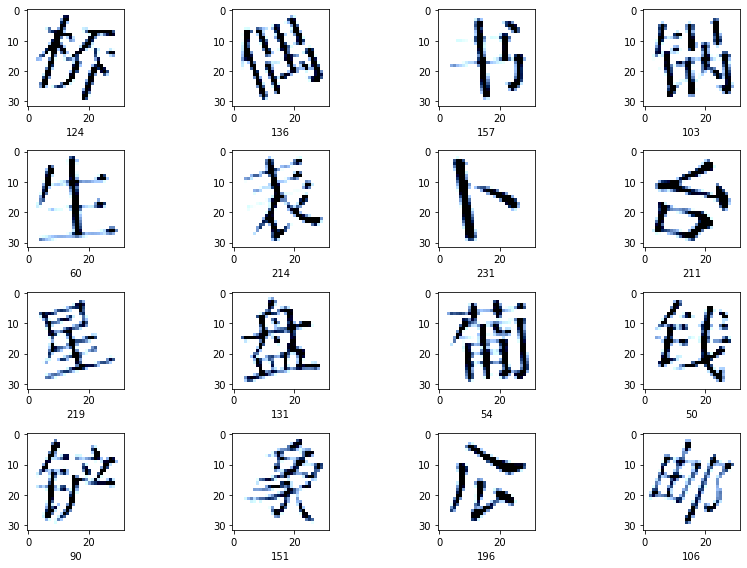

In [84]:
show_batch(image.permute([0,2,3,1]), target.numpy(), (4,4))

In [85]:
"".join([test_dataset.index2char[item] for item in target.numpy()])[:16]

'桥偶书锅生表卜台星盘葡钱铲象公邮'

## Model

In [86]:
class Model(nn.Module):
    def __init__(self, n_classes):
        super(Model, self).__init__()
        
        self.head = torch.nn.Sequential(
            torch.nn.Conv2d(3,64,kernel_size=(1,1),stride=(1,1),padding=(0,0),bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True)
        )
        
        base_model = torchvision.models.resnet34(pretrained=True)

        base_model_layers = list(base_model.children()) 
        self.body = torch.nn.Sequential(*base_model_layers[4:9])
        
        
        self.fc = torch.nn.Linear(in_features=512, out_features=n_classes, bias = True)
    
    
    def forward(self, x):
        x = self.head(x)
        x = self.body(x)
        x = x.view(-1, x.shape[1])
        logits = self.fc(x)
        probas = F.softmax(logits, dim = 1)
        return logits,probas
    
    
class CharClassificationModel(nn.Module):
    def __init__(self, n_classes):
        super(CharClassificationModel, self).__init__()


        self.upstream_model = Model(n_classes = 3755)
        checkpoint = torch.load("../models/ocr_pretrained_model_checkpoint/best_model.pt")
        self.upstream_model.load_state_dict(checkpoint["model_state_dict"])
        
        
        in_features = self.upstream_model.fc.in_features
        self.upstream_model.fc = torch.nn.Linear(in_features=in_features, out_features=n_classes, bias = True)
    
    
    def forward(self, x):
        logits,probas = self.upstream_model(x)
        return logits,probas

In [90]:
model = CharClassificationModel(n_classes = len(chars))
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=1,
        threshold=0.01,
        factor = 0.2,
        verbose=True,
        mode="max")

In [19]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def train_model(model, data_loader, optimizer, num_epochs,batch_size, device,metric_func, random_seed = 7):
    # Manual seed for deterministic data loader
    torch.manual_seed(random_seed)
    
    loss_list = []
    train_acc_list, valid_acc_list = [], []
    best_valid_acc = 0
    
    for epoch in range(num_epochs):
        start = time.time()
        # set training mode
        model.train() 
        for batch_idx, (features, targets) in enumerate(data_loader["train"]):
            features = features.to(device)
            targets = targets.to(device)


            ## forward pass
            logits, probas = model(features)
            loss = F.cross_entropy(logits,targets)

            # backward pass
            # clear the gradients of all tensors being optimized
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Login
            loss_list.append(loss.item())
            
            if batch_idx % 50 == 0:

                print ('Epoch: {0:03d}/{1:03d} | Batch {2:03d}/{3:03d} | Loss: {4:.3f}'.format(
                    epoch+1, num_epochs, batch_idx, 
                         len(train_dataset)//batch_size, loss))
        
        end = time.time()
        with torch.set_grad_enabled(False):
            train_acc = metric_func(model, data_loader["train"], device)
            valid_acc = metric_func(model, data_loader["test"], device)
            
            print('Epoch: {0:03d}/{1:03d} train acc: {2:.3f} % | val acc: {3:.3f} % | time: {4:.3f} s'.format(
                  epoch+1, num_epochs, train_acc, valid_acc, end-start))
            
            if not os.path.exists("../models/gj_model_checkpoint/"):
                os.mkdir("../models/gj_model_checkpoint/")
            
            if best_valid_acc <= valid_acc:
                best_valid_acc = valid_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'valid_acc': valid_acc,
                    'optimizer_state_dict': optimizer.state_dict(),
                }, "../models/gj_model_checkpoint/best_model.pt")
            
            
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)
        
        scheduler.step(valid_acc)
            
    checkpoint = torch.load("../models/gj_model_checkpoint/best_model.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
            
    return model, loss_list, train_acc_list, valid_acc_list

In [21]:
model, loss_list, train_acc_list, valid_acc_list = train_model(model, 
            dataset_loader, 
            optimizer, 
            NUM_EPOCHS, 
            device = DEVICE, 
            batch_size = BATCH_SIZE,
            metric_func = compute_accuracy)

Epoch: 001/010 | Batch 000/438 | Loss: 5.524
Epoch: 001/010 | Batch 050/438 | Loss: 5.248
Epoch: 001/010 | Batch 100/438 | Loss: 3.854
Epoch: 001/010 | Batch 150/438 | Loss: 2.732
Epoch: 001/010 | Batch 200/438 | Loss: 2.084
Epoch: 001/010 | Batch 250/438 | Loss: 1.374
Epoch: 001/010 | Batch 300/438 | Loss: 0.976
Epoch: 001/010 | Batch 350/438 | Loss: 0.850
Epoch: 001/010 | Batch 400/438 | Loss: 0.463
Epoch: 001/010 train acc: 99.573 % | val acc: 91.026 % | time: 38.629 s
Epoch: 002/010 | Batch 000/438 | Loss: 0.248
Epoch: 002/010 | Batch 050/438 | Loss: 0.224
Epoch: 002/010 | Batch 100/438 | Loss: 0.129
Epoch: 002/010 | Batch 150/438 | Loss: 0.198
Epoch: 002/010 | Batch 200/438 | Loss: 0.086
Epoch: 002/010 | Batch 250/438 | Loss: 0.078
Epoch: 002/010 | Batch 300/438 | Loss: 0.126
Epoch: 002/010 | Batch 350/438 | Loss: 0.052
Epoch: 002/010 | Batch 400/438 | Loss: 0.060
Epoch: 002/010 train acc: 100.000 % | val acc: 93.162 % | time: 39.200 s
Epoch: 003/010 | Batch 000/438 | Loss: 0.043


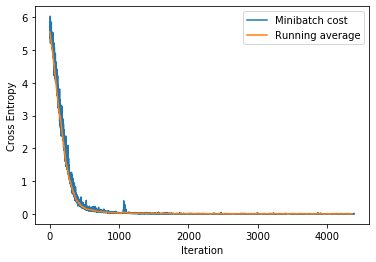

In [25]:
plt.plot(loss_list, label='Minibatch cost')
plt.plot(np.convolve(loss_list, 
                     np.ones(30,)/30, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

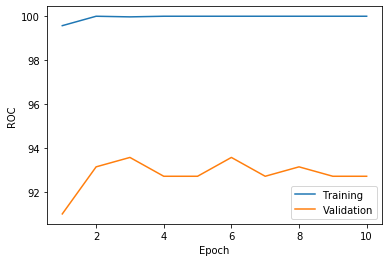

In [24]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()
plt.show()

In [22]:
model.eval()
all_preds = []
all_targets = []

for i, (features,targets) in enumerate(test_dataloader):
    features = features.to(DEVICE)
    logits,probas = model(features)
    _, predicted_labels = torch.max(probas, 1)
    all_preds += predicted_labels.tolist()
    all_targets += targets.tolist()

In [23]:
np.mean(np.array(all_preds) == np.array(all_targets))

0.9358974358974359

In [ ]:
model.to("cpu")

In [30]:
def image2text(model, chars, test_data_transform, image_path):
    img = Image.open(image_path)
    input = torch.unsqueeze(test_data_transform(img),0)    
    logits,probas = model(input)
    _, predicted_idx = torch.max(probas, 1)
    return chars[predicted_idx]
image2text(model,chars,test_data_transform,"cuts/行.png")

'行'

In [31]:
image2text(model,chars,test_data_transform,"cuts/象.png")

'象'

In [32]:
image2text(model,chars,test_data_transform,"cuts/领.png")

'领'

In [33]:
image2text(model,chars,test_data_transform,"cuts/螃.png")

'螃'

In [34]:
image2text(model,chars,test_data_transform,"cuts/蟹.png")

'蟹'